# Cuk Converter State Space Model

In [1]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca
import sympy as sym

from IPython.display import display, Math

from libs.state_space_utils import *
from libs.curve_fitting_utils import *
from libs.simulation_utils import *


circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    style="american",
    draw_nodes=True,
    label_nodes=False,
    label_ids=False,
    label_values=False,
    cpt_size=1,
    node_spacing=1.5,
    scale=1,
    dpi=150,
)


The Cuk Converter:
Stretch conflict 1.25 vs 0.75 in vertical graph for M1 between nodes (0, 0_1, 0_2, nC22, nP21) and (_gate), due to incompatible sizes


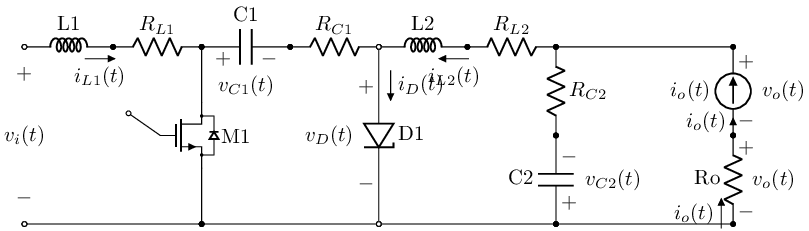

Operation step 1: Switch is ON


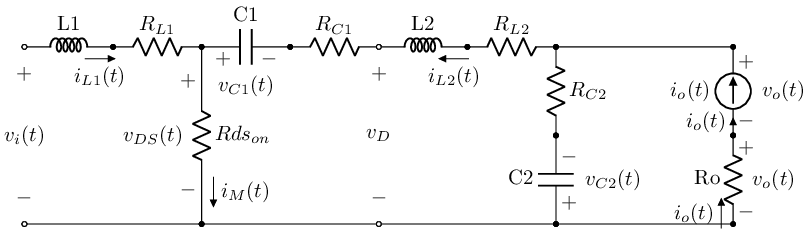

/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/.venv/lib/python3.10/site-packages/lcapy/matrix.py:244: UserWarning: 
This may take a while...  A symbolic matrix inversion is O(12^3) for a matrix
of size 12x12
  warn("""


<IPython.core.display.Math object>

Operation step 2: Switch is OFF


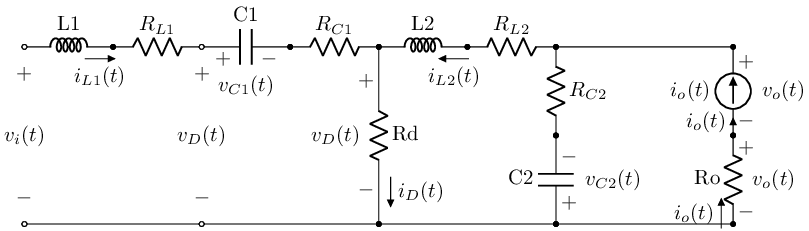

/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/.venv/lib/python3.10/site-packages/lcapy/matrix.py:244: UserWarning: 
This may take a while...  A symbolic matrix inversion is O(12^3) for a matrix
of size 12x12
  warn("""


<IPython.core.display.Math object>

Averaged Large-Signal Model:


<IPython.core.display.Math object>

Averaged Small-Signal Model - First-order linearization:


<IPython.core.display.Math object>

In [2]:
class cuk:
    def netlist(state: bool = -1):
        return "\n".join(
            filter(
                None,
                [
                    cuk._input(),
                    cuk._commutation_cell(state),
                    cuk._output(),
                ],
            )
        )

    def _input():
        source = "\n".join(
            [
                "P1 i 0; down, v={v_{i}(t)}",
                "Vi i 0 {vi(t)}; down, l={v_i(t)}, f={i_{i}(t)}, v={v_{i}(t)}, invisible",
            ]
        )
        inductor = "\n".join(
            [
                "L1 i .2; right, l^={L1}, f_>={i_{L1}(t)}",
                "RL1 L1.2 M; right, l^={R_{L1}}",
            ]
        )
        ground = "W  0    0_1; right"
        return "\n".join(filter(None, [source, inductor, ground]))

    def _commutation_cell(state: bool = -1):
        capacitor = "\n".join(
            [
                "C1 M .2; right, l^={C1}, v_={v_{C1}(t)}",
                "RC1 C1.2 D; right, l^={R_{C1}}",
            ]
        )
        if state == -1:
            switches = "\n".join(
                [
                    "M1 M _gate 0_1 nmos; nosim, right=1.5, bodydiode, arrowmos, l^={M1}, f>^={i_{M}(t)}, v_={v_{M}(t)}"
                    + ("" if state == -1 else ", invisible"),
                    "D1 D 0_2 schottky; nosim, down, l^={D1}, f>^={i_{D}(t)}, v_={v_{D}(t)}"
                    + ("" if state == -1 else ", invisible"),
                ]
            )
        else:
            switches = ""

        ground = "W  0_1 0_2; right"
        if state:
            switches_for_simulation = "\n".join(
                [
                    # "W  M 0_1; down, i={i_{M}}"
                    "Rdson  M 0_1; down=1.5, l^={Rds_{on}}, f^={i_{M}(t)}, v_={v_{DS}(t)}"
                    + (", invisible" if state == -1 else ""),
                    "P3 D 0_2; down=1.5, v={v_{D}}"
                    + (", invisible" if state == -1 else ""),
                ]
            )
        else:
            switches_for_simulation = "\n".join(
                [
                    "P3 M 0_1; down=1.5, v={v_{D}(t)}"
                    + (", invisible" if state == -1 else ""),
                    # "W  D 0_2; down, i={i_{D}}"
                    "Rd  D 0_2; down=1.5, l^={Rd}, f^={i_{D}(t)}, v_={v_{D}(t)}"
                    + (", invisible" if state == -1 else ""),
                ]
            )

        return "\n".join(
            filter(None, [capacitor, switches,
                   switches_for_simulation, ground])
        )

    def _output():
        load = "\n".join(
            [
                # Ro em paralelo com Io
                # "Ro nP21 out; up, l^={Ro}, f>^={i_{o}(t)}, v_>={v_{o}(t)}",
                # "Io out nP21 {io(t)}; down, l^={i_o(t)}, i>^={i_{o}(t)}, v_={v_{o}(t)}, invisible",
                # Ro em série com Io
                "Ro nP21 .2; up, l^={Ro}, f>^={i_{o}(t)}, v_>={v_{o}(t)}",
                "Io out Ro.2 {io(t)}; down, l^={i_o(t)}, i>^={i_{o}(t)}, v_={v_{o}(t)}",
                "W  o out; right",
            ]
        )
        inductor = "\n".join(
            [
                "L2 .1 D; left, mirror, l_={L2}, f>^={i_{L2}(t)}",
                "RL2 o L2.1; left, l_={R_{L2}}",
            ]
        )
        capacitor = "\n".join(
            [
                "C2 nC22 .2; up, l^={C2}, v_={v_{C2}(t)}",
                "RC2 C2.2 o ; up, l_={R_{C2}}",
            ]
        )
        ground = "\n".join(
            [
                "W  nC22 nP21; right=2",
                "W  0_2  nC22; right=2",
            ]
        )

        return "\n".join(filter(None, [load, inductor, capacitor, ground]))

    def describe():
        print("The Cuk Converter:")
        cct = lca.Circuit(netlist=cuk.netlist())
        cct.draw(**circuit_draw_params)

        print("Operation step 1: Switch is ON")
        cct_on = lca.Circuit(netlist=cuk.netlist(True))
        cct_on.draw(**circuit_draw_params)

        outputs = {
            'node_voltages': ['o'],
            'branch_currents': ['Vi', 'Ro'],
            # 'branch_currents': ['Vi'],
        }

        ss_on = lca.StateSpace.from_circuit(cct_on, **outputs)
        display_lcapy_ss(ss_on)

        print("Operation step 2: Switch is OFF")
        cct_off = lca.Circuit(netlist=cuk.netlist(False))
        cct_off.draw(**circuit_draw_params)

        ss_off = lca.StateSpace.from_circuit(cct_off, **outputs)
        display_lcapy_ss(ss_off)

        print("Averaged Large-Signal Model:")
        ss_lsm = get_averaged_large_signal_model(ss_on, ss_off)
        display_lcapy_ss(ss_lsm)

        print("Averaged Small-Signal Model - First-order linearization:")
        ss_ssm = get_averaged_small_signal_model(ss_on, ss_off)
        display_lcapy_ss(ss_ssm)

        return cct, cct_on, cct_off, ss_on, ss_off, ss_lsm, ss_ssm


cct, cct_on, cct_off, ss_on, ss_off, ss_lsm, ss_ssm = cuk.describe()


---

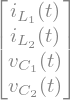

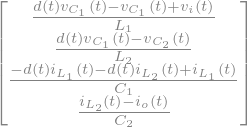

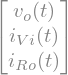

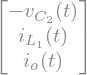

In [4]:
ss = ss_lsm.subs(
    {'Rdson': 0, 'Rd': 0, 'RC1': 0, 'RC2': 0, 'RL1': 0, 'RL2': 0}
)

x = (ss.A*ss.x + ss.B*ss.u).expand().simplify()
y = (ss.C*ss.x + ss.D*ss.u).expand().simplify()
display(ss.x, x)
display(ss.y, y)
# eq[0]

# \dot{ILi}*Li = VCc*(D-1) +Vi
# \dot{ILo}*Lo = VCc*D -VCo
# \dot{ICc}*Cc = ILi*(1-D) -D*IL2
# \dot{ICo}*Co = IL2 -ILo


In [78]:
import pandas as pd
import matplotlib.pyplot as plt

x_names = [str(expr.name).replace(
    '\hat{', '').replace('}', '') for expr in ss_ssm.x]
y_names = [str(expr.name).replace(
    '\hat{', '').replace('}', '') for expr in ss_ssm.y]
u_names = [str(expr.name).replace(
    '\hat{', '').replace('}', '') for expr in ss_ssm.u]

df = pd.read_csv("./simulations/data/MAM17_psim_simulation_varying_inputs.csv")

print(x_names)
print(y_names)
print(u_names)
print(df.columns)
df.rename(columns={
    'Time': 't',
    'I(Li)': x_names[0],
    'I(Lo)': x_names[1],
    'VC': x_names[2],
    'VCo': x_names[3],
    'Vo': y_names[0],
    'Iin': y_names[1],
    'I(Ro)': y_names[2],
    'Vin': u_names[0],
    'Io': u_names[1],
    'var_Duty_Cycle': u_names[2],
}, inplace=True)
# df[u_names[0]] = df[y_names[1]]
# df[u_names[1]] = df[y_names[6]]
df.set_index('t', drop=True, inplace=True)
# df = df[[col for col in df.columns if not col.startswith('_')]] # remove ignored columns
df = df[[*y_names, *u_names]]  # remove ignored columns

# Set initial time as zero;
df.index = df.index - df.index[0]
Ts = df.index[1] - df.index[0]
print(f"Time Step Period: {Ts}.")

# Remove non-used variables
x_names_filt = [name for name in x_names if name in df.columns]
y_names_filt = [name for name in y_names if name in df.columns]
u_names_filt = [name for name in u_names if name in df.columns]


def plot_dataset(df):
    for col in df.columns:
        plt.figure(figsize=(20, 5))
        plt.title(col)
        plt.plot(df.index, df[col], label='PSIM Simulation data')
        plt.legend(loc='lower right')
        plt.show()

# display(df)
# plot_dataset(df)


['i_L1', 'i_L2', 'v_C1', 'v_C2']
['v_o', 'i_Vi', 'i_Ro']
['vi', 'io', 'd']
Index(['Time', 'I(C)', 'I(Li)', 'I(Co)', 'I(Lo)', 'Is', 'ID', 'I(Ro)', 'Iin',
       'Io', 'VD', 'VC', 'Pmax', 'Vs', 'Vin', 'var_Duty_Cycle', 'VCo', 'Vo'],
      dtype='object')
Time Step Period: 1e-07.


## Get the simulation data
In order to test the model, let's play with a simulation data from a non-ideal Cuk simulation done in PSIM.

## Get the nominal value of the cuk's components and its nominal point of operation

In [79]:
Vo = 46.8
Po = 300
operation = {
    'Ro': Vo**2 / Po,
}
design = {
    # 'Li': 200e-6, 'Lo': 300e-6, 'Cc': 10e-6, 'Co': 5e-6
    # 'Li': 100e-6, 'Lo': 100e-6, 'Cc': 10e-6, 'Co': 10e-6
    'Li': 187e-6, 'Lo': 286e-6, 'Cc': 16e-06, 'Co': 157e-6
    # 'Li': 0.000187, 'Lo': 0.000286, 'Cc': 16e-06, 'Co': 15.7e-6
}

components = {
    'C1': design['Cc'],
    'RC1': 1e-6,
    'C2': design['Co'],
    'RC2': 1e-6,
    'L1': design['Li'],
    'RL1': 1e-6,
    'L2': design['Lo'],
    'RL2': 1e-6,
    'Rdson': 31e-3,
    'Rd': 71e-3,
    'Ro': operation['Ro'],
}

point_of_operation = {sympy_put_bar_on(sympy_expr_to_symbol(
    lca.texpr(f'{u_name}(t)'))): df[u_name].mean() for u_name in u_names}

# Get the operating point solving the Steady State:
dt = sym.Function('d')(lca.t)
Dt = sympy_put_bar_on(sympy_expr_to_symbol(dt))
subs = {lca.texpr(f'{u_name}(t)'): sympy_put_bar_on(
    sympy_expr_to_symbol(lca.texpr(f'{u_name}(t)'))) for u_name in u_names}
X_eq_rhs = (-ss_lsm.A.subs(subs).inv() * ss_lsm.B.subs(subs)
            * ss_lsm.u.subs(subs)).expand().simplify()
Y_eq_rhs = (ss_lsm.C.subs(subs) * X_eq_rhs + ss_lsm.D.subs(subs)
            * ss_lsm.u.subs(subs)).expand().simplify()
U_eq_rhs = sym.Matrix([sympy_put_bar_on(sympy_expr_to_symbol(
    lca.texpr(f'{u_name}(t)'))) for u_name in u_names])

VoltageGain_eq = sym.Eq(
    (ss_lsm.y[0] / ss_lsm.u[0]).expr, (X_eq_rhs[1] / X_eq_rhs[2]).expr.collect(Dt))
# display(VoltageGain_eq)
Dt_eq_rhs = sym.solve(VoltageGain_eq.rhs.collect(
    Dt) - VoltageGain_eq.lhs, Dt)[0]  # TODO: use lcapy to solve it

# display(X_eq_rhs)
# display(Y_eq_rhs)

X_eq = sym.Eq(sym.Matrix(x_names).applyfunc(sympy_put_bar_on), sym.N(
    X_eq_rhs.subs({**components, **point_of_operation}).simplify()), evaluate=False)
Y_eq = sym.Eq(sym.Matrix(y_names).applyfunc(sympy_put_bar_on), sym.N(
    Y_eq_rhs.subs({**components, **point_of_operation}).simplify()), evaluate=False)
U_eq = sym.Eq(U_eq_rhs, U_eq_rhs.subs(point_of_operation), evaluate=False)
# Dt_eq = sym.Eq(Dt, Dt_eq_rhs, evaluate=False)
# display(X_eq)
# display(Y_eq)
# display(U_eq)
# display(Dt_eq)

# Substitute variables to get the numerical state space system
values = {
    **components,
    **point_of_operation,
    **{X_eq.lhs[i]: X_eq.rhs[i] for i in range(len(X_eq.rhs))}
}
# display(values)

ss_vals = ss_ssm.subs(values)
# display_lcapy_ss(ss_vals)
print('Is controlable:', ss_vals.is_controllable)
print('Is observable:', ss_vals.is_observable)

# display(sym.N(ss_vals.singular_values))
# display(sym.N(ss_vals.balanced_transformation))


Is controlable: True
Is observable: True


## State Space Simulation

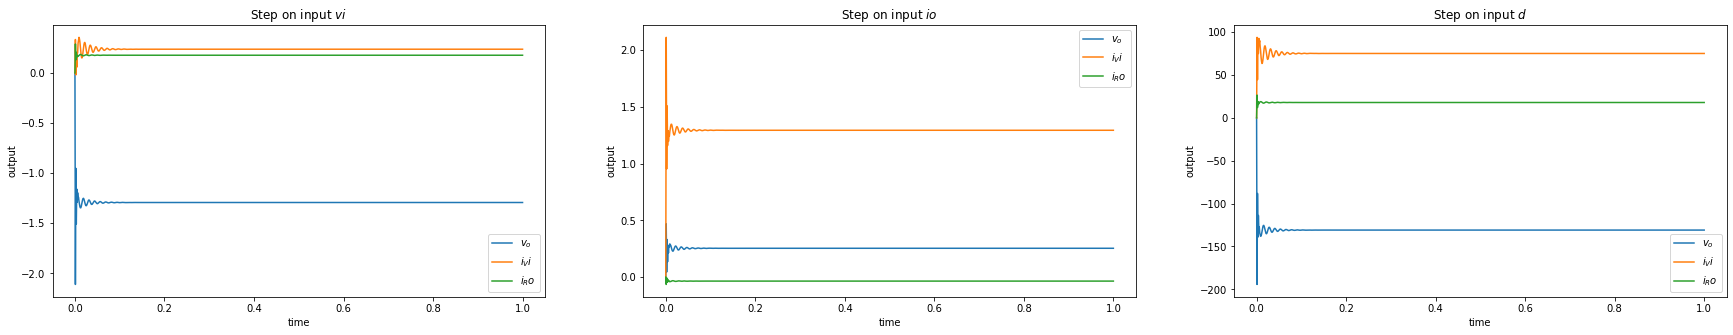

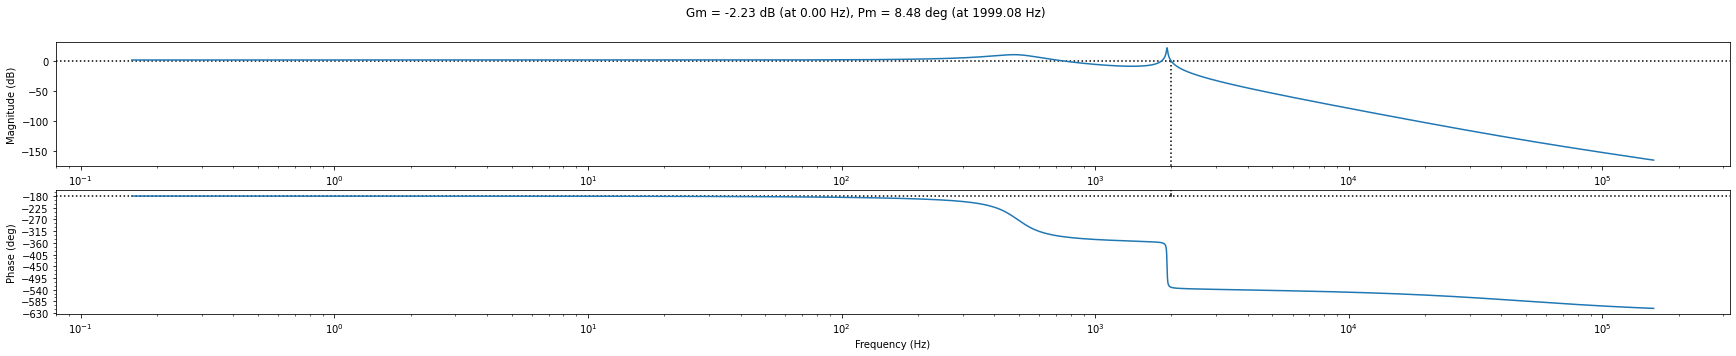

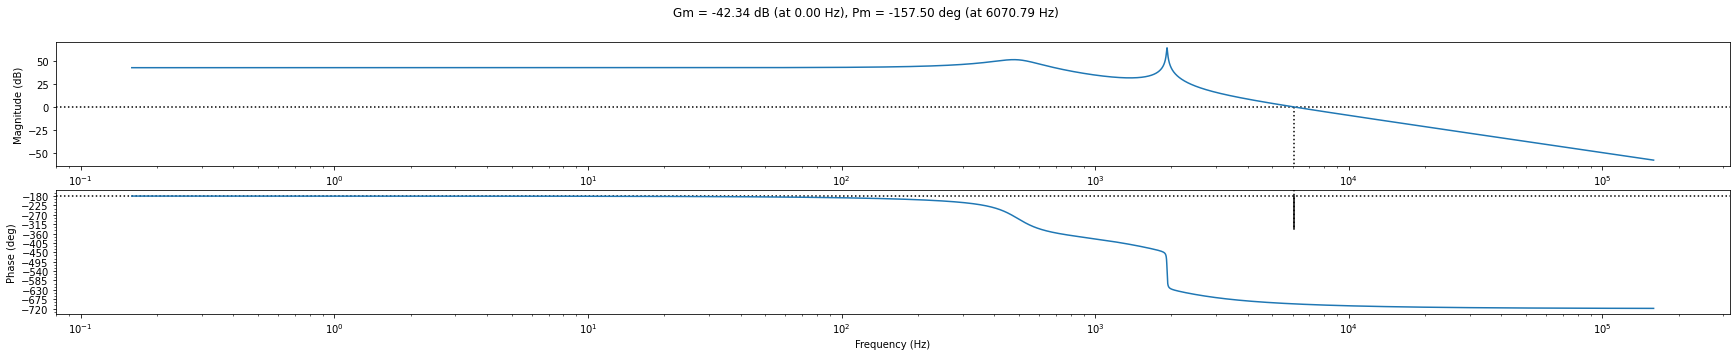

In [84]:
import control
from scipy import signal

ss = lcapy_statespace_to_pythoncontrol(ss_vals)
ss.set_inputs(inputs=u_names)
ss.set_outputs(outputs=y_names)
ss.set_states(states=x_names)

t = np.linspace(0, 1, 1001)
_, yu1 = control.step_response(ss, t, input=0, squeeze=True)
_, yu2 = control.step_response(ss, t, input=1, squeeze=True)
_, yu3 = control.step_response(ss, t, input=2, squeeze=True)

plt.figure(1, figsize=(3*10, 5))
plt.subplot(1, 3, 1)
plt.plot(t, yu1[0], label=f'${y_names[0]}$')
plt.plot(t, yu1[1], label=f'${y_names[1]}$')
plt.plot(t, yu1[2], label=f'${y_names[2]}$')
plt.xlabel('time')
plt.ylabel('output')
plt.legend()
plt.title(f'Step on input ${u_names[0]}$')

plt.subplot(1, 3, 2)
plt.plot(t, yu2[0], label=f'${y_names[0]}$')
plt.plot(t, yu2[1], label=f'${y_names[1]}$')
plt.plot(t, yu2[2], label=f'${y_names[2]}$')
plt.xlabel('time')
plt.ylabel('output')
plt.legend()
plt.title(f'Step on input ${u_names[1]}$')

plt.subplot(1, 3, 3)
plt.plot(t, yu3[0], label=f'${y_names[0]}$')
plt.plot(t, yu3[1], label=f'${y_names[1]}$')
plt.plot(t, yu3[2], label=f'${y_names[2]}$')
plt.xlabel('time')
plt.ylabel('output')
plt.legend()
plt.title(f'Step on input ${u_names[2]}$')

# print(ss.dcgain())

tfs = control.ss2tf(ss)
tf_vo_vi = tfs[tfs.find_output('v_o'), tfs.find_input('vi')]
tf_ii_vi = tfs[tfs.find_output('i_Vi'), tfs.find_input('vi')]
tf_vo_d = tfs[tfs.find_output('v_o'), tfs.find_input('d')]
# display(tf_vo_vi)
# display(tf_ii_vi)
# display(tf_vo_d)

bode_cfg = dict(plot=True, omega_limits=[
    1, 1e6], omega_num=int(1e5), margins=True, Hz=True, deg=True, dB=True)

plt.figure(figsize=(30, 5))
control.bode_plot(tf_vo_vi, **bode_cfg)
# plt.suptitle("Vo(s) / Vi(s)")
plt.show()

plt.figure(figsize=(30, 5))
control.bode_plot(tf_vo_d, **bode_cfg)
# plt.suptitle("Vo(s) / d(s)")
plt.show()


# Parametrização por meio de otimização

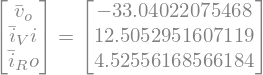

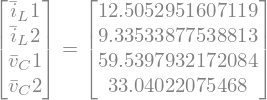

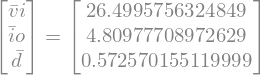

In [85]:
display(Y_eq)
display(X_eq)
display(U_eq)


In [86]:
import lmfit

# Initial values
C1_0 = components['C1']
RC1_0 = components['RC1']
C2_0 = components['C2']
RC2_0 = components['RC2']
L1_0 = components['L1']
RL1_0 = components['RL1']
L2_0 = components['L2']
RL2_0 = components['RL2']
Rdson_0 = components['Rdson']
Rd_0 = components['Rd']
Ro_0 = components['Ro']

# Maximum values
max_mult = 20
C1_max = max_mult * C1_0
RC1_max = max_mult * RC1_0
C2_max = max_mult * C2_0
RC2_max = max_mult * RC2_0
L1_max = max_mult * L1_0
RL1_max = max_mult * RL1_0
L2_max = max_mult * L2_0
RL2_max = max_mult * RL2_0
Rdson_max = max_mult * Rdson_0
Rd_max = max_mult * Rd_0
Ro_max = max_mult * Ro_0

# Minimum values
min_mult = 0.05
C1_min = min_mult * C1_0
RC1_min = min_mult * RC1_0
C2_min = min_mult * C2_0
RC2_min = min_mult * RC2_0
L1_min = min_mult * L1_0
RL1_min = min_mult * RL1_0
L2_min = min_mult * L2_0
RL2_min = min_mult * RL2_0
Rdson_min = min_mult * Rdson_0
Rd_min = min_mult * Rd_0
Ro_min = min_mult * Ro_0

params = lmfit.Parameters()
# NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP
params.add_many(
    ('C1', C1_0, True, C1_min, C1_max, None, None),
    ('RC1', RC1_0, True, RC1_min, RC1_max, None, None),
    ('C2', C2_0, True, C2_min, C2_max, None, None),
    ('RC2', RC2_0, True, RC2_min, RC2_max, None, None),
    ('L1', L1_0, True, L1_min, L1_max, None, None),
    ('RL1', RL1_0, True, RL1_min, RL1_max, None, None),
    ('L2', L2_0, True, L2_min, L2_max, None, None),
    ('RL2', RL2_0, True, RL2_min, RL2_max, None, None),
    ('Rdson', Rdson_0, True, Rdson_min, Rdson_max, None, None),
    ('Rd', Rd_0, True, Rd_min, Rd_max, None, None),
    ('Ro', Ro_0, True, Ro_min, Ro_max, None, None),
)
display(params)


name,value,initial value,min,max,vary
C1,1.6000e-05,1.6e-05,8.0000e-07,3.2000e-04,True
RC1,1.0000e-06,1e-06,5.0000e-08,2.0000e-05,True
C2,1.5700e-04,0.000157,7.8500e-06,0.00314000,True
RC2,1.0000e-06,1e-06,5.0000e-08,2.0000e-05,True
L1,1.8700e-04,0.000187,9.3500e-06,0.00374000,True
RL1,1.0000e-06,1e-06,5.0000e-08,2.0000e-05,True
L2,2.8600e-04,0.000286,1.4300e-05,0.00572000,True
RL2,1.0000e-06,1e-06,5.0000e-08,2.0000e-05,True
Rdson,0.03100000,0.031,0.00155000,0.62000000,True
Rd,0.07100000,0.071,0.00355000,1.42000000,True


In [87]:
import lmfit


def ss_cuk(C1, RC1, C2, RC2, L1, RL1, L2, RL2, Rdson, Rd, Ro) -> control.StateSpace:
    components = {
        'C1': C1,
        'RC1': RC1,
        'C2': C2,
        'RC2': RC2,
        'L1': L1,
        'RL1': RL1,
        'L2': L2,
        'RL2': RL2,
        'Rdson': Rdson,
        'Rd': Rd,
        'Ro': Ro,
    }
    values = {
        **components,
        **point_of_operation,
    }
    Xss = X_eq_rhs.subs(values).expr
    Yss = np.array(Y_eq_rhs.subs(values).expr, dtype=np.float64)
    Uss = np.array(U_eq_rhs.subs(values), dtype=np.float64)
    values = {
        **values,
        **{X_eq.lhs[i]: Xss[i] for i in range(len(X_eq.lhs))},
    }
    return lcapy_statespace_to_pythoncontrol(ss_ssm.subs(values)), Yss, Uss


def simulate_cuk(ss: control.StateSpace, Yss: np.array, Uss: np.array, T: np.array, U: np.array) -> np.array:
    U -= Uss.T  # Remove large signals from the data
    _T, Y, U = control.forced_response(ss, T=T.T, U=U.T, squeeze=True, return_x=True)
    Y += Yss  # Add the large signal back to the data
    return Y


def func(T: np.array, U: np.array,
         C1, RC1, C2, RC2, L1, RL1, L2, RL2, Rdson, Rd, Ro) -> np.array:
    ss, Yss, Uss = ss_cuk(C1, RC1, C2, RC2, L1, RL1, L2, RL2, Rdson, Rd, Ro)
    return simulate_cuk(ss, Yss, Uss, T, U)


model = lmfit.Model(
    func=func,
    independent_vars=['T', 'U'],
    param_names=list(params.valuesdict().keys())
)


In [97]:
t = np.arange(start=0, stop=0.1, step=1e-3)
k = len(t)

def step(t, start, stop=None):
    u = np.ones_like(t)

    step_start = np.argmax(t > start)
    u[:step_start] = 0

    if stop is not None:
        step_stop = np.argmax(t > stop)
        u[step_stop:] = 0

    return u

Po = 100
Vo = 10
IRo = Po / Vo
Io = 0
Vi = Vo
Pi = Po
Ii = Pi / Vi
d = Vo / (Vo + Vi)

df_udata = pd.DataFrame({
    't': t,
    u_names[0]: Vi * np.ones_like(t), # vi
    u_names[1]: Io * np.ones_like(t), # io
    u_names[2]: d * np.ones_like(t), # d
    y_names[0]: Vo * np.ones_like(t), # vo
    y_names[1]: Ii * np.ones_like(t),  # ii
    y_names[2]: IRo * np.ones_like(t),  # iro
}).set_index('t')

df_simul = simulate(model, df_udata, y_names, u_names, point_of_operation, params)
print(df_simul.mean())
print(df_udata.mean())
# df_simul.plot(subplots=True, figsize=(20,len(df_simul.columns)*3));


vi      10.000000
io       0.000000
d        0.500000
v_o     -3.338923
i_Vi    -3.086507
i_Ro     0.457337
dtype: float64
vi      10.0
io       0.0
d        0.5
v_o     10.0
i_Vi    10.0
i_Ro    10.0
dtype: float64


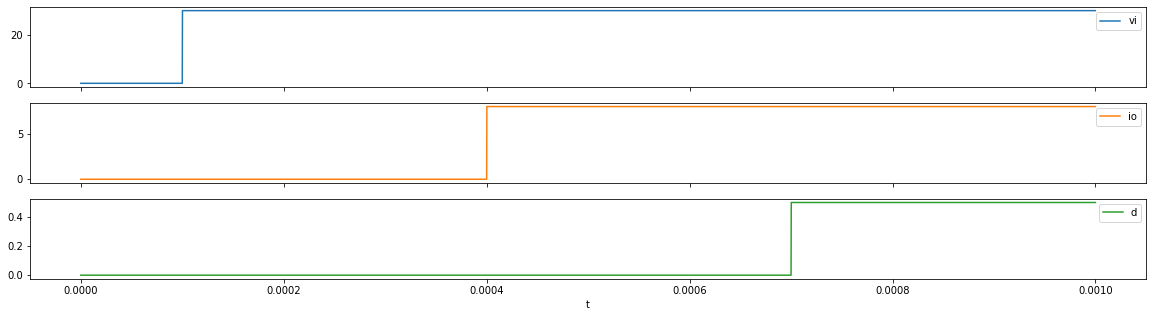

In [ ]:
t = np.arange(start=0, stop=0.001, step=1e-7)
k = len(t)

def step(t, start, stop=None):
    u = np.ones_like(t)

    step_start = np.argmax(t > start)
    u[:step_start] = 0

    if stop is not None:
        step_stop = np.argmax(t > stop)
        u[step_stop:] = 0

    return u

df_udata = pd.DataFrame({
    't': t,
    u_names[0]: 30. * step(t, 1e-4), # vi
    u_names[1]: 8.0 * step(t, 4e-4), # io
    u_names[2]: 0.5 * step(t, 7e-4), # d
}).set_index('t')

df_udata.plot(subplots=True, figsize=(20,5));

100 70 30


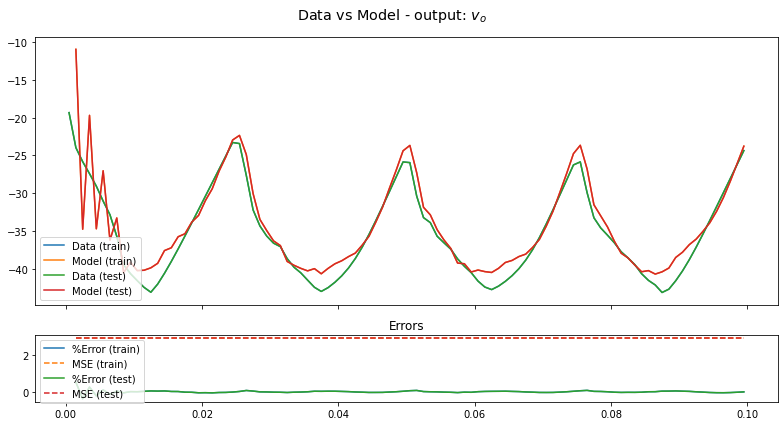

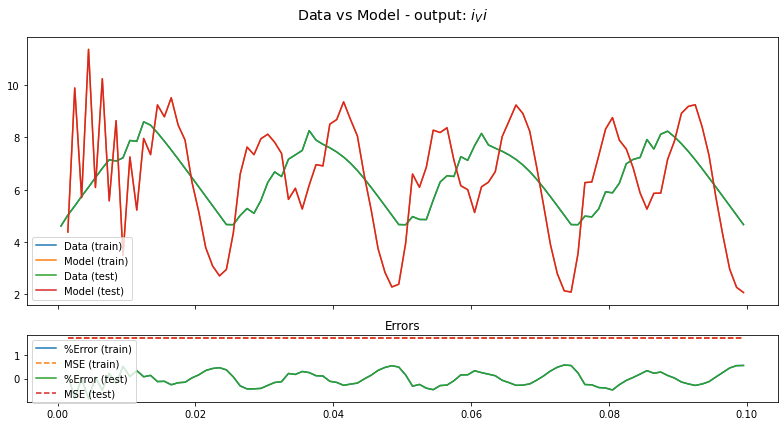

In [62]:
# Split the dataset into train/test datasets from a downsampled dataset:
df_downsampled = downsampling_dataframe(df[[*u_names, *y_names]], 10000)
df_train, df_test = split_train_test(df=df_downsampled, test_size=0.3)
print(len(df_downsampled), len(df_train), len(df_test))
# plot_train_test(df_train, df_test, y_names+u_names)

eval_and_plot(model, df_downsampled, df_downsampled,
              y_names, u_names, point_of_operation, params)


In [63]:
df_train = df_train.copy()

# Let's say we have no output current data
# df_train['i_Ro'] = float(0)
# So we can disable the evaluation of the output current using weights:
df_weights = df_train[[*y_names]] / df_train[[*y_names]]
# df_weights['i_Ro'] = float(0)

# This is an input, it will always be right, so we ignore it.
# df_weights['i_Ii'] = float(0)

# The State Space will never be right on the first iteration, so we can ignore it too:
delay = len(x_names)
df_weights.iloc[0:delay] = float(0)

display(df_train.head())
display(df_weights.head(6))


,d,i_Vi,io,v_o,vi
t,,,,,
0.0005,0.597327,4.613202,2.644880,-19.351527,13.696179
0.0015,0.602724,5.031034,3.276488,-23.972751,15.750485
0.0025,0.602021,5.379003,3.530768,-25.833217,17.321724
0.0035,0.603490,5.749255,3.746300,-27.410176,18.041732
0.0045,0.603984,6.099133,3.971477,-29.057707,19.242904


,v_o,i_Vi
t,,
0.0005,0.0,0.0
0.0015,0.0,0.0
0.0025,0.0,0.0
0.0035,0.0,0.0
0.0045,1.0,1.0
0.0055,1.0,1.0


In [64]:
# To be easier/faster, we can relax the default tolerances:
fit_kws = {
    # Relative error in the approximate solution, default: 1e-7.
    'xtol': 1e-3,
    # Relative error in the desired sum-of-squares, default: 1e-7.
    'ftol': 1e-3,
}

# local methods:
method = 'leastsq'  # ~30~50s
result = model_fit(
    model, params, method, df_train, y_names, u_names, point_of_operation,
    fit_kws=fit_kws,
    # df_weights=df_weights,
)
lmfit.model.save_modelresult(result, 'cuk_modelresult_no_current.sav')
display(result)


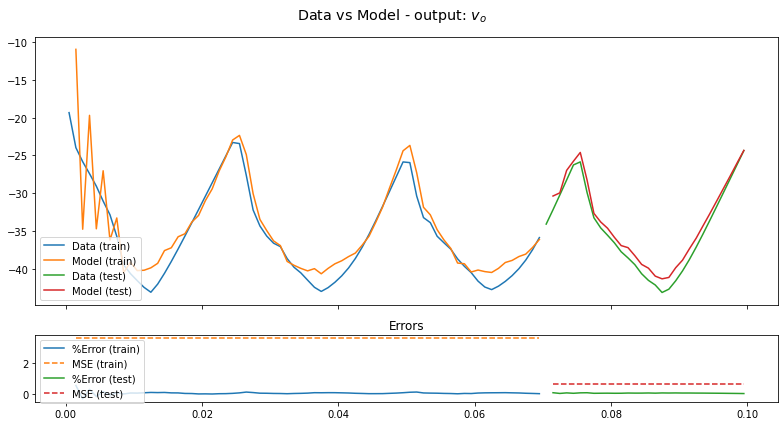

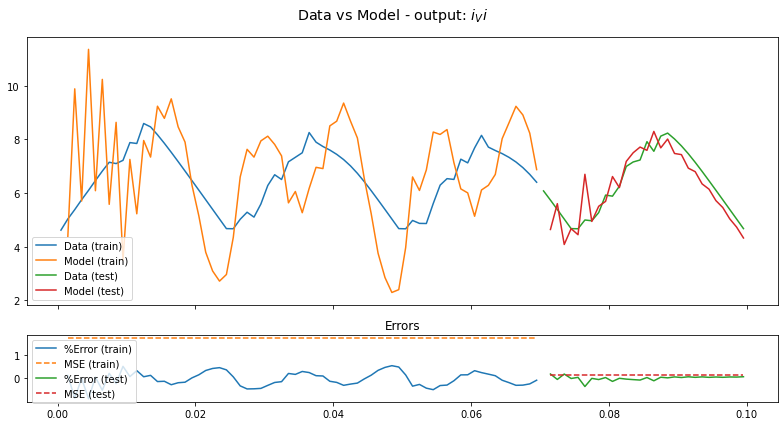

In [65]:
import lmfit
import matplotlib.pyplot as plt

# Loads the model from file
result = lmfit.model.load_modelresult(
    'cuk_modelresult_no_current.sav', funcdefs={'func': func})

df_model = eval_and_plot(result, df_train, df_test,
                         y_names, u_names, point_of_operation)

# plot_AB(df, df_model, y_names, "Data", "Model", "Data vs Model for the entire original dataset", "Comparison")
